# Strategy 2 - Distinguish Predator and Victim

In [ ]:
!pip install transformers

In [2]:
from google.colab import drive
from config import *
from utils import *
from classification import *
from bert import *

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import NearMiss
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3 as sqlite
import seaborn as sns
import torch

%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Increases the size limit of DataFrame columns
pd.set_option('display.max_colwidth', 500)

# Number of messages per conversation
CONVERSATION_SIZE = 24

# Folder to save results
RESULTS_FOLDER = RESULTS_PATH + 'Estrategia2/'

In [5]:
# Checking if GPU is available to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Using:', device)
print('CUDA available:', torch.cuda.is_available())
print('GPU:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else '-')

Using: cuda:0
CUDA available: True
GPU: Tesla P100-PCIE-16GB


**Connecting to SQLite**


In [6]:
connection = sqlite.connect('database.db')

print("Connection established!");

Connection established!


## Functions

In [7]:
def getDatasetInformation(df):
  print('UPDATED DATASET INFORMATION')
  print('----------------------------------------------\n')

  print('Number of conversations: ', len(df['conversation_id'].value_counts()))
  print('Number of authors: ', len(df['author'].value_counts()))
  print('-')

  dfPredators = df[df['predator'] == True]
  print('Number of predatory conversations: ', len(dfPredators['conversation_id'].value_counts()))
  print('Number of sexual predators:', len(dfPredators['author'].value_counts())) 

In [8]:
def callClassifier(algorithm, df, X, y, conversationSize, sample_indices_undersampling=[], splits=10, device='cpu', epochs=10, batch_size=32):
  if algorithm == "bert":
    indexes, metrics = classifyWithBERT(X, y, conversationSize, splits, device, epochs, batch_size)
  else:
    indexes, metrics = classify(algorithm, X, y, conversationSize, splits)

  predators = []

  # Returns the ID of predators according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predators.append(df.loc[sample_indices_undersampling[i]]['author'])
  else:
    for i in indexes:
      predators.append(df.loc[i]['author'])

  #print('Number of sexual predators: ' , len(predators))
  #print(predators)
  
  return indexes, metrics, predators

In [9]:
def callTestClassifier(algorithm, df, X_train, y_train, X_test, y_test, conversationSize, sample_indices_undersampling=[]):
  indexes, metrics = testClassify(algorithm, X_train, y_train, X_test, y_test, conversationSize)
  predators = []

  # Returns the ID of predators according to the index in the dataframe
  if len(sample_indices_undersampling):
    for i in indexes:
      predators.append(df.loc[sample_indices_undersampling[i]]['author'])
  else:
    for i in indexes:
      predators.append(df.loc[i]['author'])

  #print('Number of sexual predators: ' , len(predators))
  #print(predators)
  
  return indexes, metrics, predators

## Import preprocessed training dataset

In [10]:
dfBase = pd.read_csv(DRIVE_PATH + 'databases/training_predators_preprocessed.csv', sep=';', na_filter=False)

In [11]:
dfBase

,conversation_id,line,author,time,message,predator
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,False
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,False
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,False
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,False
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,False
...,...,...,...,...,...,...
873197,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,False
873198,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,True
873199,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,False
873200,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,True


In [12]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

## Group messages by author

**Data before grouping**

In [13]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
Number of authors:  97287
-
Number of predatory conversations:  1972
Number of sexual predators: 142


**Grouping**

In [14]:
dfGroupedMessages = groupMessagesByAuthor(connection, dfBase, CONVERSATION_SIZE)

In [15]:
dfGroupedMessages

,conversation_id,author,messages,predator
0,0000604306a283600b730276a2039471,a9b326df4e6da61c5b6f5e1058be83a2,b8810fee2f4a71f849f3f7409546d1d9 do you have any set of test cases for non conformant html5 b8810fee2f4a71f849f3f7409546d1d9 btw do you have a good estimate of many man hours you have put into work on the conformance checker including hours of any others that contributed to it significantly fantasai maybe im just curious b8810fee2f4a71f849f3f7409546d1d9 ok was just thinking mainly about the html5 part and thinking it might be good to eventually try to have an rough estimate of how many man h...,False
1,0000604306a283600b730276a2039471,b8810fee2f4a71f849f3f7409546d1d9,a9b326df4e6da61c5b6f5e1058be83a2 there are some in the syntax module a9b326df4e6da61c5b6f5e1058be83a2 ive also used annes wf 2 0 tests but using those in the test harness in now broken as the spec stabilizes it makes sense to write more tests a9b326df4e6da61c5b6f5e1058be83a2 no estimate lots a9b326df4e6da61c5b6f5e1058be83a2 the upper bound i can give is that theres no code written by me in there that predates october 2003 and the validation service started around november 2004 iirc work towa...,False
2,0000604306a283600b730276a2039471,e3fb62ebfa4f36acf5cbff6a6ed0f2e0,sean fraser posted this on january 22 2007 08 30 am,False
3,0001347c00d419eb537c0692e6e58eba,67952953f11f8800aa8296b1457d2c01,asl,False
4,0001347c00d419eb537c0692e6e58eba,e2bd430b29412d9267886e187ba28075,say asl and ill rip your heart out grr rips your heart out and eats it,False
...,...,...,...,...
139622,ffffe01fc5b03a8d6b8c929d595644d9,24340ef160b44f4e9d826263c6dd3188,jamesd i thought you needed mash karrot x download and do perl makefile pl like a fucking non pussy a href,False
139623,ffffe01fc5b03a8d6b8c929d595644d9,7ef291c89ad915978b203d427919cfbb,man where the hell is the eggs bangers are here we cant have bangers without eggs and some here would think that beans are necessary as well meriwether i possibly but datastream aj z0 and hali are the expert on that subject karrot x you have it confused with hip hop seems about right you trying to get your funky email solution working,False
139624,ffffe01fc5b03a8d6b8c929d595644d9,8a2ec3d80a45ba71f61da6da97613e11,ya,False
139625,ffffe01fc5b03a8d6b8c929d595644d9,8cd806e5c7f4f95937df692d3b8a3554,goops god damnit i hate cpan cpan is the biggest anus leak allowed for man jamesd heh when you install bundle package and then the only error you get is install seems impossible wtf jamesd something like that im actually not doing the same thing spamassassin just needs some perl modules,False


In [16]:
# Saving dataframe in SQLite database
dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

**Data after grouping - Some authors may be lost because they join the conversation after the limit of messages per conversations**

In [17]:
getDatasetInformation(dfGroupedMessages)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
Number of authors:  94585
-
Number of predatory conversations:  1972
Number of sexual predators: 142


## Delete conversations that doesn't have only 2 authors

**Data before deleting conversations**

In [18]:
getDatasetInformation(dfGroupedMessages)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
Number of authors:  94585
-
Number of predatory conversations:  1972
Number of sexual predators: 142


**Deleting conversations that doesn't have only 2 authors**

In [19]:
# Number of conversations that doesn't have only 2 authors
query = '''SELECT conversation_id
           FROM conversations_grouped
           GROUP BY conversation_id
           HAVING count(distinct(author)) <> 2;'''

df = pd.read_sql(query, connection)

# Getting IDs of conversations that doesn't have only 2 authors
idConversations = df['conversation_id'].values
print('Number of conversations that doesn\'t have only 2 authors:', len(idConversations))

Number of conversations that doesn't have only 2 authors: 21100


In [20]:
# Delete tuples of conversations that doesn't have only 2 authors
query = '''DELETE FROM conversations_grouped WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))

c = connection.cursor()
c.execute(query, (idConversations))
connection.commit()

print("Total:", c.rowcount, "records deleted successfully!")

Total: 48423 records deleted successfully!


In [21]:
query = '''SELECT * FROM conversations_grouped'''

dfGroupedMessages = pd.read_sql(query, connection)
dfGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
dfGroupedMessages

,conversation_id,author,messages,predator
0,0001347c00d419eb537c0692e6e58eba,67952953f11f8800aa8296b1457d2c01,asl,False
1,0001347c00d419eb537c0692e6e58eba,e2bd430b29412d9267886e187ba28075,say asl and ill rip your heart out grr rips your heart out and eats it,False
2,000197b21283dc47810760e499d1f8ec,487862cd4ec27d841e2d2e80e8d91955,joint in my hand marijuana can i see your boobs no can i see your boobs want to se emy dick i show you my dick if i see your boobs,False
3,000197b21283dc47810760e499d1f8ec,5c7c53f63bb8d380cdfe112056bb4e85,sorry im korea student i m korea boobs,False
4,0002ee38ac5e78e7edbc4d4a556ec4b7,8150320816528784d7dfe286d781de4c,hey male or female australian male here yes ask the question,False
...,...,...,...,...
91199,fffdb82e3d5078c7828024ac4855bffd,df3acd271e182256675b562848e530a3,hi asl,False
91200,fffdd9142e809a7f634fbcc13063146d,5d48b1237df684fb908bd17cd1bf7f2b,u first p hi male too,False
91201,fffdd9142e809a7f634fbcc13063146d,efe5f457e24831849d715590843593d8,hey asl 20 m us u,False
91202,ffff38287b6013960b9e96e08f85526a,229e965572105f6b069f522906d9151f,hello kjlkj,False


**Data after deleting conversations**

In [22]:
getDatasetInformation(dfGroupedMessages)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  45602
Number of authors:  84129
-
Number of predatory conversations:  1087
Number of sexual predators: 138


**Number of words per conversation**

In [23]:
getConversationsWithMoreWords(dfGroupedMessages)

,conversation_id,words,messages
21558,3c98f24025742ea1d9ea8b3990071732,2002,read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems began to...
2388,06649fab7088fa8a4c58ccd27ac4d3d8,1410,the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of the city to a h...
54383,9862471a316571ab4bad3ae68cf72c5e,1080,hii als how are you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmoneycontrol com excel charts in secondsautomatically summarize and ass...
76755,d6c836f0eb4b27b86eabbd8b216331e1,1036,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be ...
41936,75fef10a08b0ce3b7cfc95348f9ae300,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
20351,392948cfa674493892902952449aef71,856,kill me while i molest you look like a i love piss you look like a fuck with me you like a foolish dancing your mom will love you look like a irish men never gonna fuck luigi you look like a please hurt me while i molest you look like a i love piss you never gonna fuck with me you look like a foolish nazi where i belong you look like a irish men never gonna fuck with me you look like a you disturb me while i molest you look like a i love penis you never gonna fuck with me you look like a foo...
10678,1e27624c3009e13ab708d46babf06fc7,790,stranger hi you stranger hey you im a horny girl please me you my name is anna stranger uhm sure stranger my names rei stranger nice to fuck you ok d you i would love that stranger how big are your tits you medium size stranger they can fit stranger im into kinky shit is that ok you yes d you i dont mind you i saw my sister fuck her bf and i got horny stranger wow youre one slutty chick you lol thanks d you also bi stranger thats extremely slutty stranger you be lovin my cock long time you a...
16840,2f38276c3766946553bf8e02a1470cca,782,you fucking americans are the biggest pervs on omegle freaking bigoted nigger go and suck your mums stinking anus or suck

## Remove repeated words in sequence after grouping

In [24]:
i=0
for message in dfGroupedMessages['messages']:
  m = re.search(r'\b(.+)\s+\1\b', message)
  if m and m.group(0).strip():
    i=i+1
    #print(m.group(0))

print('Number of messages with some repeated word:', i)

Number of messages with some repeated word: 4501


In [25]:
# Store the messages before for later comparison
dfGroupedMessages['messages_before'] = dfGroupedMessages['messages']

dfGroupedMessages['messages'] = dfGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))

In [26]:
# Saving dataframe in SQLite database
dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

**Comparing amount of words before and after removing repeated words**

In [27]:
df = dfGroupedMessages.copy()
df['words_before'] = df['messages_before'].str.count(' ') + 1
df['words_after'] = df['messages'].str.count(' ') + 1

df[['words_before', 'messages_before', 'words_after', 'messages']].sort_values(by=['words_before'], ascending = False).head(10)

,words_before,messages_before,words_after,messages
21558,2002,read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems began to...,2002,read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems began to...
2388,1410,the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of the city to a h...,1410,the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of the city to a h...
54383,1080,hii als how are you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmoneycontrol com excel charts in secondsautomatically summarize and ass...,1080,hii als how are you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmoneycontrol com excel charts in secondsautomatically summarize and ass...
76755,1036,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be ...,190,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying vvyguihjkroigfdvivgyu v ficial messages from omegle will not be sent with the label stranger strange

In [28]:
# Dropping column "messages_before"
dfGroupedMessages.drop('messages_before', inplace=True, axis=1)

**Number of words per conversation**

In [29]:
getConversationsWithMoreWords(dfGroupedMessages)

,conversation_id,words,messages
21558,3c98f24025742ea1d9ea8b3990071732,2002,read this declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems began to...
2388,06649fab7088fa8a4c58ccd27ac4d3d8,1410,the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of the city to a h...
54383,9862471a316571ab4bad3ae68cf72c5e,1080,hii als how are you what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmoneycontrol com excel charts in secondsautomatically summarize and ass...
41936,75fef10a08b0ce3b7cfc95348f9ae300,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
10678,1e27624c3009e13ab708d46babf06fc7,790,stranger hi you stranger hey you im a horny girl please me you my name is anna stranger uhm sure stranger my names rei stranger nice to fuck you ok d you i would love that stranger how big are your tits you medium size stranger they can fit stranger im into kinky shit is that ok you yes d you i dont mind you i saw my sister fuck her bf and i got horny stranger wow youre one slutty chick you lol thanks d you also bi stranger thats extremely slutty stranger you be lovin my cock long time you a...
13691,268742179cf547cca6792731708c462e,707,hi want a car computer ipod x box etc for free just deposit 10 to my paypal account at my paypal id email and just email me your address at my id any random id nobody cares p anything of your wish hi you are our 10 thousand daily chatting stranger at omegle you have won a lottry prize of 10 000 to claim the prize just deposit 10 through your paypal account at this paypal id email and just email your address at this id any random id nobody cares p this money is been taken from you for securit...
2226,05f5b2119260313889c7b87d52bd1381,694,hi given the existence as uttered forth in the public works of puncher and wattmann of a personal god quaquaquaqua with white beard quaquaquaqua outside time without extension who from the heights of divine apathia divine athambia divine aphasia loves us dearly with some exceptions for reasons unknown but time will tell and suffers like the divine miranda with those who for reasons unknown but time will tell are plunged in torment plunged in fire whose fire flames if that continues and who c...
48664,88b4a0b1c954f4f43c835c32e2d756de,640,stranger i am lord voldemort you ok stranger what is your name you my name is karen and im a professional psychologist stra

## Feature extraction

### Bag of Words

In [30]:
vectorizer = CountVectorizer(analyzer='word')
bagofwords = vectorizer.fit_transform(dfGroupedMessages['messages'])

In [31]:
bagofwords

<91204x50092 sparse matrix of type '<class 'numpy.int64'>'
	with 922675 stored elements in Compressed Sparse Row format>

In [32]:
# Separating X and Y

X = bagofwords
y = dfGroupedMessages['predator']

[(False, 90117), (True, 1087)]
Dataset shape Counter({False: 90117, True: 1087})


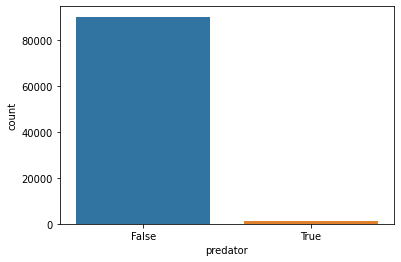

In [33]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

### BERT

In [ ]:
# Tokenize messages

tokens = tokenizeMessagesBERT(dfGroupedMessages['messages'])

In [ ]:
# Checking if all words are in BERT vocabulary

text = " ".join(message for message in dfGroupedMessages['messages'])
print('Number of words:', len(text.split())+1)

unknownWords = []
tokenizer = Tokenizer()
vocab = tokenizer.tokenizer.get_vocab()

for word in text.split():
  if vocab.get(word) == None:
    unknownWords.append(word)

print('Total unknown words:', len(unknownWords))
print('Total unknown words without duplicates:', len(set(unknownWords)))

In [ ]:
# Generating embeddings

embeddings = generateEmbeddingsBERT(tokens)

In [ ]:
# Creating a dataframe with the embeddings

dfEmbeddingsBERT = pd.DataFrame(embeddings)
dfEmbeddingsBERT.info()

In [ ]:
# Saving embeddings

f = DRIVE_PATH + 'databases/training_predators_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT.to_csv(f, index=False, header=True, sep=';')

In [ ]:
# Separating X and Y

X = dfEmbeddingsBERT
y = dfGroupedMessages['predator']

In [ ]:
print(sorted(Counter(y).items()))
print('Dataset shape %s' % Counter(y))

ax = sns.countplot(x=y)

## Imbalanced classification

In [ ]:
indexesNBM, metricsNBM, predatorsNBM = callClassifier('naive_bayes_multinomial', dfGroupedMessages, X, y, CONVERSATION_SIZE)
indexesRF, metricsRF, predatorsRF = callClassifier('random_forest', dfGroupedMessages, X, y, CONVERSATION_SIZE)
indexesKNN, metricsKNN, predatorsKNN = callClassifier('knn', dfGroupedMessages, X, y, CONVERSATION_SIZE)
indexesSVM, metricsSVM, predatorsSVM = callClassifier('svm', dfGroupedMessages, X, y, CONVERSATION_SIZE)
indexesNN, metricsNN, predatorsNN = callClassifier('neural_network_mlp', dfGroupedMessages, X, y, CONVERSATION_SIZE)

**BERT**

In [ ]:
# Read embeddings
f = DRIVE_PATH + 'databases/training_predators_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT = pd.read_csv(f, sep=';')

X = dfEmbeddingsBERT
y = dfGroupedMessages['predator']

In [ ]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
indexesBERT, metricsBERT, predatorsBERT = callClassifier('bert', dfGroupedMessages, X.values, y.values, CONVERSATION_SIZE, [], splits, device, epochs, batch_size)

## Balanced classification

**Balancing classes - Undersampling**

[(False, 1087), (True, 1087)]


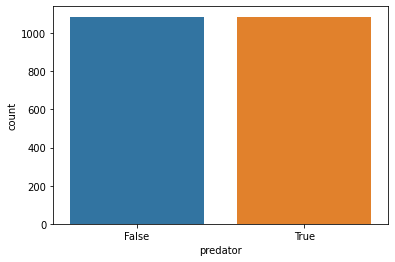

In [34]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

ax = sns.countplot(x=y_resampled)

In [ ]:
indexesNBM, metricsNBM, predatorsNBM = callClassifier('naive_bayes_multinomial', dfGroupedMessages, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesRF, metricsRF, predatorsRF = callClassifier('random_forest', dfGroupedMessages, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesKNN, metricsKNN, predatorsKNN = callClassifier('knn', dfGroupedMessages, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesSVM, metricsSVM, predatorsSVM = callClassifier('svm', dfGroupedMessages, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)
indexesNN, metricsNN, predatorsNN = callClassifier('neural_network_mlp', dfGroupedMessages, X_resampled, y_resampled, CONVERSATION_SIZE, nm.sample_indices_)

**BERT**

In [ ]:
# Read embeddings
f = DRIVE_PATH + 'databases/training_predators_embeddings_bert_{}messages.csv'.format(CONVERSATION_SIZE)
dfEmbeddingsBERT = pd.read_csv(f, sep=';')

X = dfEmbeddingsBERT
y = dfGroupedMessages['predator']

In [ ]:
splits = 10
epochs = 50

# Defines the size of training and evaluation batches - 16 or 32
batch_size = 32

In [ ]:
nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

In [ ]:
indexesBERT, metricsBERT, predatorsBERT = callClassifier('bert', dfGroupedMessages, X_resampled.values, y_resampled.values, CONVERSATION_SIZE, nm.sample_indices_, splits, device, epochs, batch_size)

## Visualizing conversations

**Naive Bayes Multinomial**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesNBM)]

**Random Forest**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesRF)]

**KNN**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesKNN)]

**SVM**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesSVM)]

**Neural Network MLP**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesNN)]

**BERT**

In [ ]:
dfGroupedMessages[dfGroupedMessages.index.isin(indexesBERT)]

## Graphics

In [35]:
# Colors 
colorNBM = 'green'
colorRF = 'purple'  
colorKNN = 'orange'
colorSVM = 'red' 
colorNN = 'black'
colorBERT = 'blue' 

# Labels
labelNBM = 'Naive Bayes'
labelRF = 'Floresta Aleatória'
labelKNN = 'KNN'
labelSVM = 'SVM'
labelNN = 'Rede Neural'
labelBERT = 'BERT'

marker = '' # '' or 'o'
markersize = 6

xticks = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
yticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

yticksPredatorsTuples = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
yticksPredators = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

### Imbalanced classification

#### Training

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNBM = dict()
metricsNBM['acc_list'] = []
metricsNBM['precision_list'] = []
metricsNBM['recall_list'] = []
metricsNBM['f1_list'] = []
metricsNBM['f0_5_list'] = []

metricsRF = dict()
metricsRF['acc_list'] = []
metricsRF['precision_list'] = []
metricsRF['recall_list'] = []
metricsRF['f1_list'] = []
metricsRF['f0_5_list'] = []

metricsKNN = dict()
metricsKNN['acc_list'] = []
metricsKNN['precision_list'] = []
metricsKNN['recall_list'] = []
metricsKNN['f1_list'] = []
metricsKNN['f0_5_list'] = []

metricsSVM = dict()
metricsSVM['acc_list'] = []
metricsSVM['precision_list'] = []
metricsSVM['recall_list'] = []
metricsSVM['f1_list'] = []
metricsSVM['f0_5_list'] = []

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []

metricsBERT = dict()
metricsBERT['loss_list'] = []
metricsBERT['best_epochs_list'] = []
metricsBERT['acc_list'] = []
metricsBERT['precision_list'] = []
metricsBERT['recall_list'] = []
metricsBERT['f1_list'] = []
metricsBERT['f0_5_list'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  # Group messages
  dfGroupedMessages = groupMessagesByAuthor(connection, dfBase, i)
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped'''
  dfGroupedMessages = pd.read_sql(query, connection)
  dfGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessages['messages'] = dfGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessages['messages'])
  X = bagofwords
  y = dfGroupedMessages['predator']
  
  # Naive Bayes Multinomial
  _, metrics, predatorsNBM = callClassifier('naive_bayes_multinomial', dfGroupedMessages, X, y, i)
  metricsNBM['acc_list'].append(metrics['accuracy_avg'])
  metricsNBM['precision_list'].append(metrics['precision_avg'])
  metricsNBM['recall_list'].append(metrics['recall_avg'])
  metricsNBM['f1_list'].append(metrics['f1_avg'])
  metricsNBM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # Random Forest
  _, metrics, predatorsRF = callClassifier('random_forest', dfGroupedMessages, X, y, i)
  metricsRF['acc_list'].append(metrics['accuracy_avg'])
  metricsRF['precision_list'].append(metrics['precision_avg'])
  metricsRF['recall_list'].append(metrics['recall_avg'])
  metricsRF['f1_list'].append(metrics['f1_avg'])
  metricsRF['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # KNN
  _, metrics, predatorsKNN = callClassifier('knn', dfGroupedMessages, X, y, i)
  metricsKNN['acc_list'].append(metrics['accuracy_avg'])
  metricsKNN['precision_list'].append(metrics['precision_avg'])
  metricsKNN['recall_list'].append(metrics['recall_avg'])
  metricsKNN['f1_list'].append(metrics['f1_avg'])
  metricsKNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # SVM
  _, metrics, predatorsSVM = callClassifier('svm', dfGroupedMessages, X, y, i)
  metricsSVM['acc_list'].append(metrics['accuracy_avg'])
  metricsSVM['precision_list'].append(metrics['precision_avg'])
  metricsSVM['recall_list'].append(metrics['recall_avg'])
  metricsSVM['f1_list'].append(metrics['f1_avg'])
  metricsSVM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics
  
  # Neural Network MLP
  _, metrics, predatorsNN = callClassifier('neural_network_mlp', dfGroupedMessages, X, y, i)
  metricsNN['acc_list'].append(metrics['accuracy_avg'])
  metricsNN['precision_list'].append(metrics['precision_avg'])
  metricsNN['recall_list'].append(metrics['recall_avg'])
  metricsNN['f1_list'].append(metrics['f1_avg'])
  metricsNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # BERT
  f = DRIVE_PATH + 'databases/training_predators_embeddings_bert_{}messages.csv'.format(i)
  dfEmbeddingsBERT = pd.read_csv(f, sep=';')
  X = dfEmbeddingsBERT
  y = dfGroupedMessages['predator']
  epochs = 50
  batch_size = 32
  _, metrics, predatorsBERT = callClassifier('bert', dfGroupedMessages, X.values, y.values, i, n_splits, device, epochs, batch_size)
  metricsBERT['loss_list'].append(metrics['loss_avg'])
  metricsBERT['best_epochs_list'].append(metrics['best_epochs'])  
  metricsBERT['acc_list'].append(metrics['accuracy_avg'])
  metricsBERT['precision_list'].append(metrics['precision_avg'])
  metricsBERT['recall_list'].append(metrics['recall_avg'])
  metricsBERT['f1_list'].append(metrics['f1_avg'])
  metricsBERT['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNBM = {}\n'.format(metricsNBM))
f.write('metricsRF = {}\n'.format(metricsRF))
f.write('metricsKNN = {}\n'.format(metricsKNN))
f.write('metricsSVM = {}\n'.format(metricsSVM))
f.write('metricsNN = {}\n'.format(metricsNN))
f.write('metricsBERT = {}\n'.format(metricsBERT))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Accuracy**

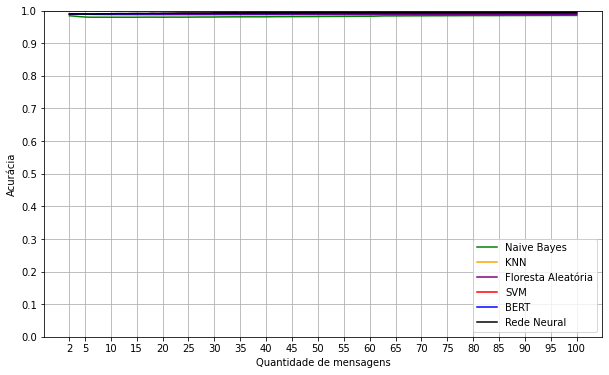

In [37]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['acc_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['acc_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['acc_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['acc_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['acc_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

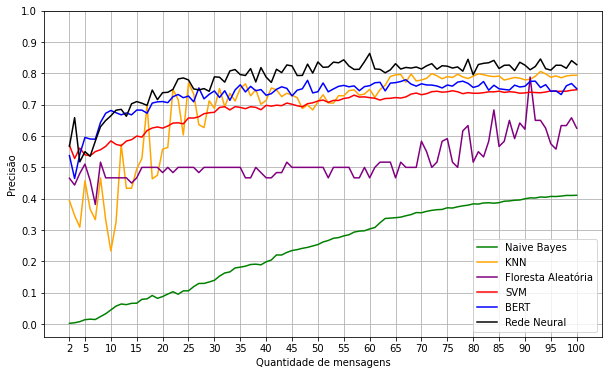

In [38]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['precision_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['precision_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['precision_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['precision_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['precision_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

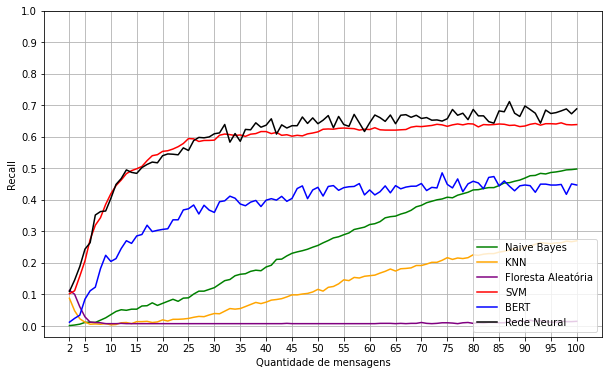

In [39]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['recall_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['recall_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['recall_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['recall_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['recall_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

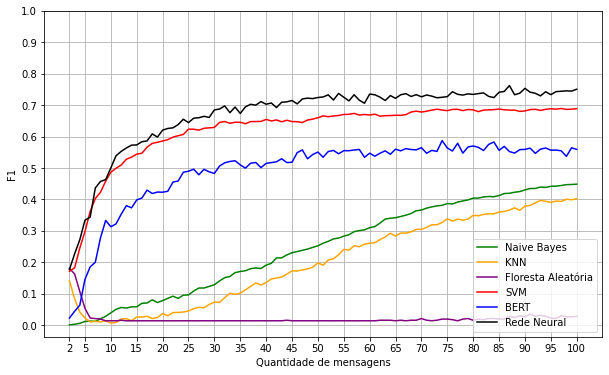

In [40]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f1_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f1_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f1_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f1_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f1_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

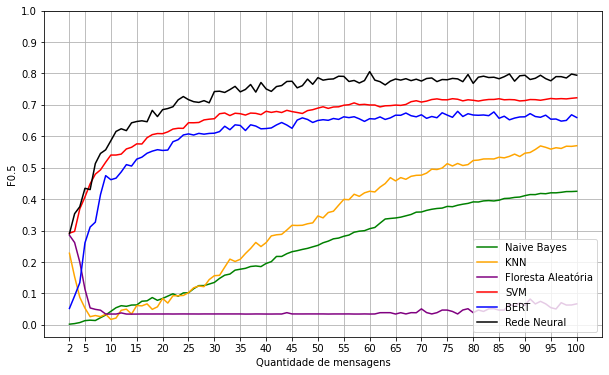

In [41]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f0_5_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f0_5_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f0_5_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f0_5_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f0_5_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

#### Test

**Import preprocessed test dataset**

In [ ]:
dfTestBase = pd.read_csv(DRIVE_PATH + 'databases/test_predators_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBase.to_sql('conversations_test', connection, if_exists='replace', index=False)

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []
metricsNN['total_predators_tuples'] = []
metricsNN['predators'] = []
metricsNN['identified_predators_tuples'] = []
metricsNN['correct_predators_tuples'] = []
metricsNN['total_predators'] = []
metricsNN['correct_predators'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessages = groupMessagesByAuthor(connection, dfBase, i)
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped'''
  dfGroupedMessages = pd.read_sql(query, connection)
  dfGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessages['messages'] = dfGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessages['messages'])
  y_train = dfGroupedMessages['predator']
  
  ############################ TEST ############################

  # Group messages
  dfTestGroupedMessages = groupMessagesByAuthor(connection, dfTestBase, i)
  dfTestGroupedMessages.to_sql('conversations_grouped_test', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped_test GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_test WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_test'''
  dfTestGroupedMessages = pd.read_sql(query, connection)
  dfTestGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfTestGroupedMessages['messages'] = dfTestGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessages.to_sql('conversations_grouped_test', connection, if_exists='replace', index=False)

  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessages['messages'])
  y_test = dfTestGroupedMessages['predator']
  
  # Neural Network MLP
  indexesNN, metrics, predatorsNN = callTestClassifier('neural_network_mlp', dfTestGroupedMessages, X_train, y_train, X_test, y_test, i)
  metricsNN['acc_list'].append(metrics['accuracy'])
  metricsNN['precision_list'].append(metrics['precision'])
  metricsNN['recall_list'].append(metrics['recall'])
  metricsNN['f1_list'].append(metrics['f1'])
  metricsNN['f0_5_list'].append(metrics['f0_5'])

  # total number of predators tuples
  metricsNN['total_predators_tuples'].append(len(y_test[y_test == True]))

  # number of identified predators
  metricsNN['identified_predators_tuples'].append(len(predatorsNN))
  metricsNN['predators'].append(predatorsNN)

  # number of correctly identified predators
  correct_predators_tuples = dfTestGroupedMessages[dfTestGroupedMessages.index.isin(indexesNN) & dfTestGroupedMessages['predator'] == True]
  metricsNN['correct_predators_tuples'].append(len(correct_predators_tuples))

  # total number of predators
  total_predators = dfTestGroupedMessages[dfTestGroupedMessages['predator'] == True]['author'].unique()
  metricsNN['total_predators'].append(len(total_predators))

  # number of correctly identified predators
  correct_predators = dfTestGroupedMessages[dfTestGroupedMessages.index.isin(indexesNN) & dfTestGroupedMessages['predator'] == True]['author'].unique()
  metricsNN['correct_predators'].append(len(correct_predators))

  del metrics

  
# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNN = {}\n'.format(metricsNN))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Predator (tuples)**

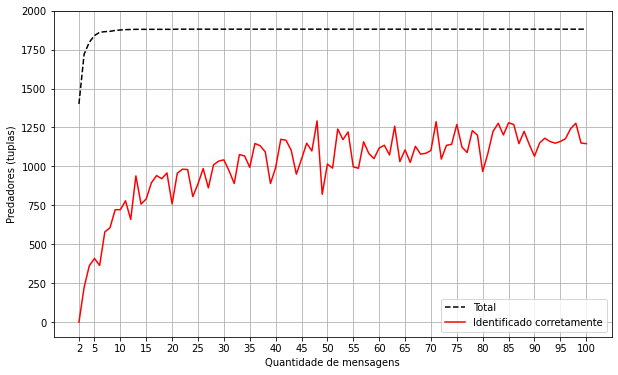

In [51]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators_tuples'], color='black', label='Total', linestyle='--')
# plt.plot(messages, metricsNN['identified_predators_tuples'], color='blue', label='Identificado', marker=marker, markerfacecolor='blue', markersize=markersize)
plt.plot(messages, metricsNN['correct_predators_tuples'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredatorsTuples)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores (tuplas)')
plt.grid(True)
plt.legend(loc='lower right')

**Predators**

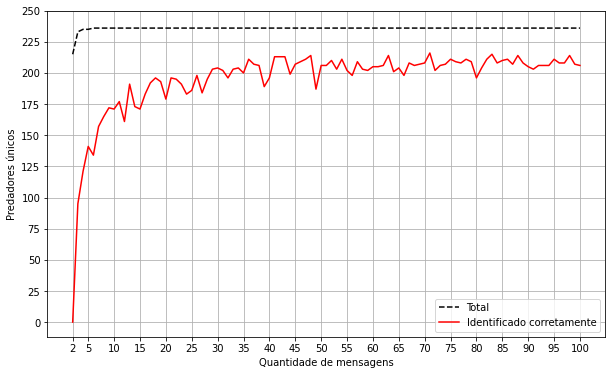

In [52]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators'], color='black', label='Total', linestyle='--')
plt.plot(messages, metricsNN['correct_predators'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredators)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores únicos')
plt.grid(True)
plt.legend(loc='lower right')

**Accuracy**

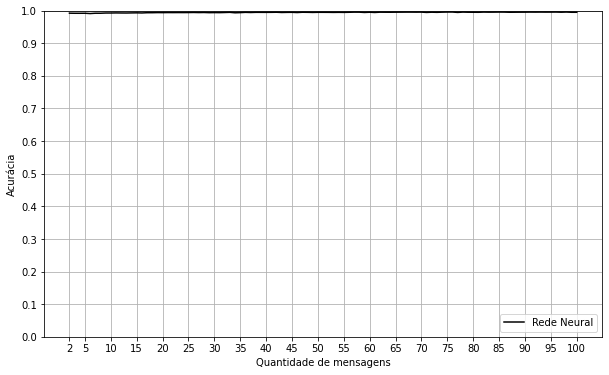

In [46]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

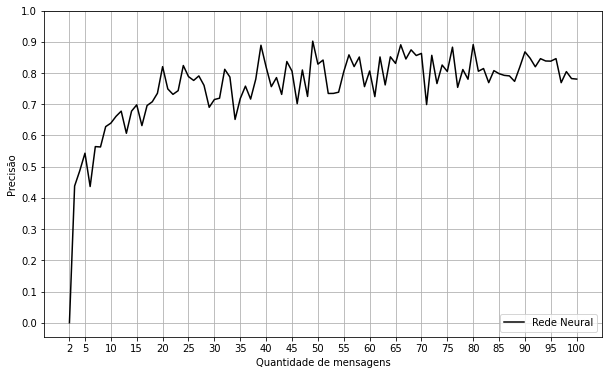

In [47]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

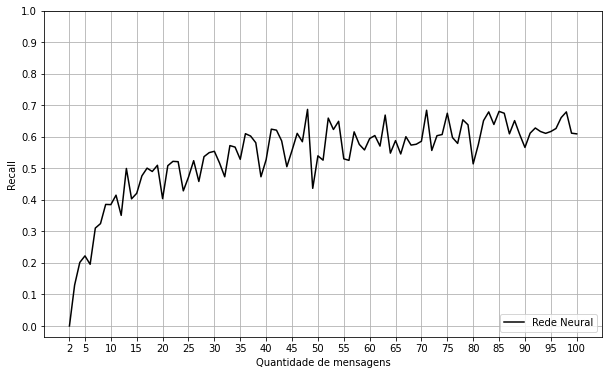

In [48]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

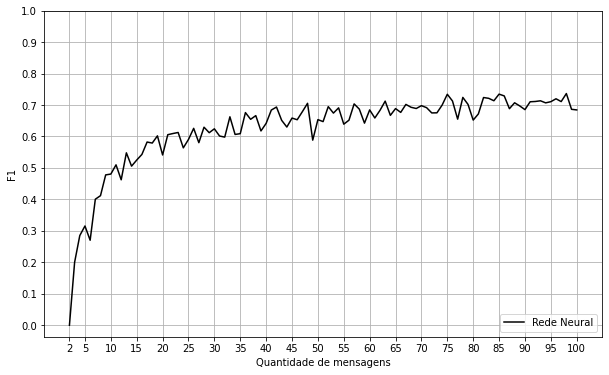

In [49]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

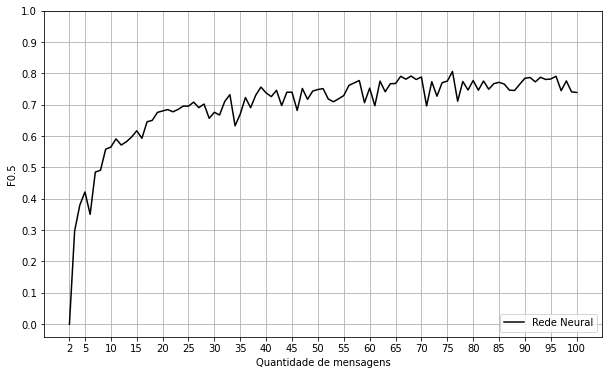

In [50]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

### Balanced classification

#### Training

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNBM = dict()
metricsNBM['acc_list'] = []
metricsNBM['precision_list'] = []
metricsNBM['recall_list'] = []
metricsNBM['f1_list'] = []
metricsNBM['f0_5_list'] = []

metricsRF = dict()
metricsRF['acc_list'] = []
metricsRF['precision_list'] = []
metricsRF['recall_list'] = []
metricsRF['f1_list'] = []
metricsRF['f0_5_list'] = []

metricsKNN = dict()
metricsKNN['acc_list'] = []
metricsKNN['precision_list'] = []
metricsKNN['recall_list'] = []
metricsKNN['f1_list'] = []
metricsKNN['f0_5_list'] = []

metricsSVM = dict()
metricsSVM['acc_list'] = []
metricsSVM['precision_list'] = []
metricsSVM['recall_list'] = []
metricsSVM['f1_list'] = []
metricsSVM['f0_5_list'] = []

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []

metricsBERT = dict()
metricsBERT['loss_list'] = []
metricsBERT['best_epochs_list'] = []
metricsBERT['acc_list'] = []
metricsBERT['precision_list'] = []
metricsBERT['recall_list'] = []
metricsBERT['f1_list'] = []
metricsBERT['f0_5_list'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  # Group messages
  dfGroupedMessages = groupMessagesByAuthor(connection, dfBase, i)
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped'''
  dfGroupedMessages = pd.read_sql(query, connection)
  dfGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessages['messages'] = dfGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  bagofwords = vectorizer.fit_transform(dfGroupedMessages['messages'])
  X = bagofwords
  y = dfGroupedMessages['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X, y = nm.fit_resample(X, y)
  
  # Naive Bayes Multinomial
  _, metrics, predatorsNBM = callClassifier('naive_bayes_multinomial', dfGroupedMessages, X, y, i, nm.sample_indices_)
  metricsNBM['acc_list'].append(metrics['accuracy_avg'])
  metricsNBM['precision_list'].append(metrics['precision_avg'])
  metricsNBM['recall_list'].append(metrics['recall_avg'])
  metricsNBM['f1_list'].append(metrics['f1_avg'])
  metricsNBM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # Random Forest
  _, metrics, predatorsRF = callClassifier('random_forest', dfGroupedMessages, X, y, i, nm.sample_indices_)
  metricsRF['acc_list'].append(metrics['accuracy_avg'])
  metricsRF['precision_list'].append(metrics['precision_avg'])
  metricsRF['recall_list'].append(metrics['recall_avg'])
  metricsRF['f1_list'].append(metrics['f1_avg'])
  metricsRF['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # KNN
  _, metrics, predatorsKNN = callClassifier('knn', dfGroupedMessages, X, y, i, nm.sample_indices_)
  metricsKNN['acc_list'].append(metrics['accuracy_avg'])
  metricsKNN['precision_list'].append(metrics['precision_avg'])
  metricsKNN['recall_list'].append(metrics['recall_avg'])
  metricsKNN['f1_list'].append(metrics['f1_avg'])
  metricsKNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # SVM
  _, metrics, predatorsSVM = callClassifier('svm', dfGroupedMessages, X, y, i, nm.sample_indices_)
  metricsSVM['acc_list'].append(metrics['accuracy_avg'])
  metricsSVM['precision_list'].append(metrics['precision_avg'])
  metricsSVM['recall_list'].append(metrics['recall_avg'])
  metricsSVM['f1_list'].append(metrics['f1_avg'])
  metricsSVM['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics
  
  # Neural Network MLP
  _, metrics, predatorsNN = callClassifier('neural_network_mlp', dfGroupedMessages, X, y, i, nm.sample_indices_)
  metricsNN['acc_list'].append(metrics['accuracy_avg'])
  metricsNN['precision_list'].append(metrics['precision_avg'])
  metricsNN['recall_list'].append(metrics['recall_avg'])
  metricsNN['f1_list'].append(metrics['f1_avg'])
  metricsNN['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics

  # BERT
  f = DRIVE_PATH + 'databases/training_predators_embeddings_bert_{}messages.csv'.format(i)
  dfEmbeddingsBERT = pd.read_csv(f, sep=';')
  X = dfEmbeddingsBERT
  y = dfGroupedMessages['predator']
  # Balancing classes - Undersampling
  nm = NearMiss()
  X, y = nm.fit_resample(X, y)
  epochs = 50
  batch_size = 32 # Defines the size of training and evaluation batches - 16 or 32
  _, metrics, predatorsBERT = callClassifier('bert', dfGroupedMessages, X.values, y.values, i, nm.sample_indices_, n_splits, device, epochs, batch_size)
  metricsBERT['loss_list'].append(metrics['loss_avg'])
  metricsBERT['best_epochs_list'].append(metrics['best_epochs'])  
  metricsBERT['acc_list'].append(metrics['accuracy_avg'])
  metricsBERT['precision_list'].append(metrics['precision_avg'])
  metricsBERT['recall_list'].append(metrics['recall_avg'])
  metricsBERT['f1_list'].append(metrics['f1_avg'])
  metricsBERT['f0_5_list'].append(metrics['f0_5_avg'])
  del metrics


# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNBM = {}\n'.format(metricsNBM))
f.write('metricsRF = {}\n'.format(metricsRF))
f.write('metricsKNN = {}\n'.format(metricsKNN))
f.write('metricsSVM = {}\n'.format(metricsSVM))
f.write('metricsNN = {}\n'.format(metricsNN))
f.write('metricsBERT = {}\n'.format(metricsBERT))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Accuracy**

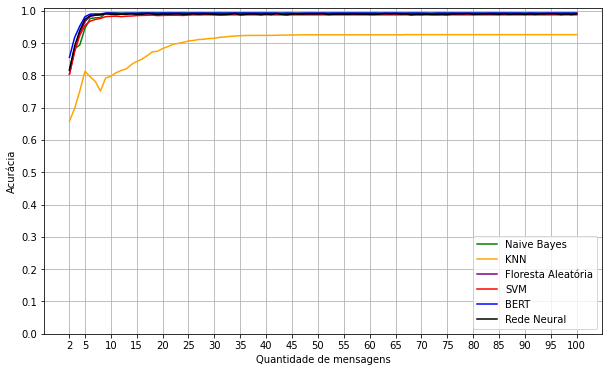

In [54]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['acc_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['acc_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['acc_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['acc_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['acc_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

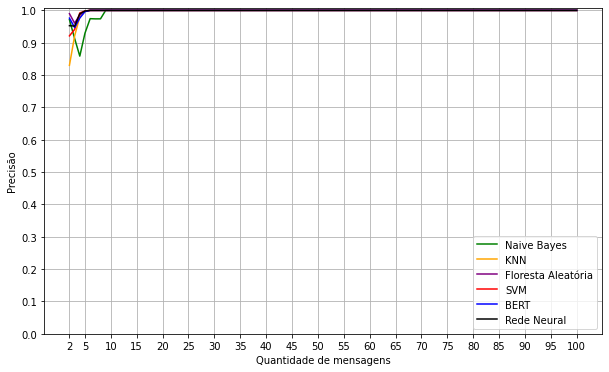

In [55]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['precision_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['precision_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['precision_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['precision_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['precision_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

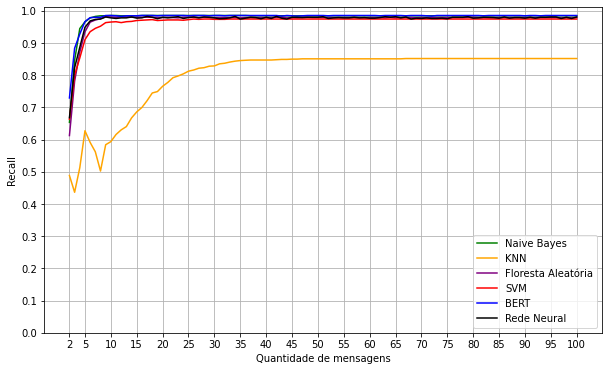

In [56]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['recall_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['recall_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['recall_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['recall_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['recall_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

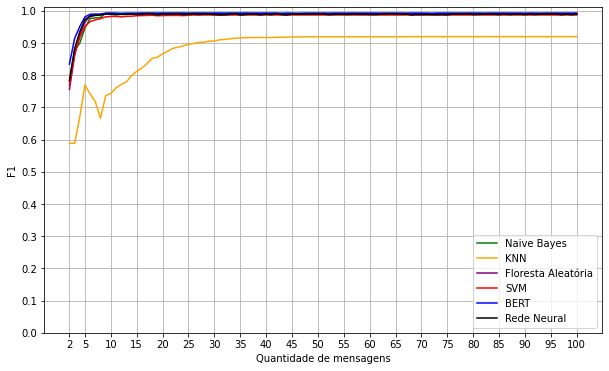

In [57]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f1_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f1_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f1_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f1_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f1_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

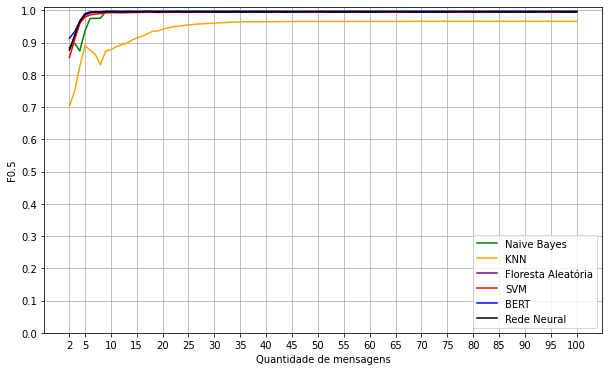

In [58]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNBM['f0_5_list'], color=colorNBM, label=labelNBM, marker=marker, markerfacecolor=colorNBM, markersize=markersize)
plt.plot(messages, metricsKNN['f0_5_list'], color=colorKNN, label=labelKNN, marker=marker, markerfacecolor=colorKNN, markersize=markersize)
plt.plot(messages, metricsRF['f0_5_list'], color=colorRF, label=labelRF, marker=marker, markerfacecolor=colorRF, markersize=markersize)
plt.plot(messages, metricsSVM['f0_5_list'], color=colorSVM, label=labelSVM, marker=marker, markerfacecolor=colorSVM, markersize=markersize)
plt.plot(messages, metricsBERT['f0_5_list'], color=colorBERT, label=labelBERT, marker=marker, markerfacecolor=colorBERT, markersize=markersize)
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')

#### Test

**Import preprocessed training dataset**

In [ ]:
dfTestBase = pd.read_csv(DRIVE_PATH + 'databases/test_predators_preprocessed.csv', sep=';', na_filter=False)

# Saving dataframe in SQLite database
dfTestBase.to_sql('conversations_test', connection, if_exists='replace', index=False)

In [ ]:
messages = list(range(2, 101))
n_splits = 10

metricsNN = dict()
metricsNN['acc_list'] = []
metricsNN['precision_list'] = []
metricsNN['recall_list'] = []
metricsNN['f1_list'] = []
metricsNN['f0_5_list'] = []
metricsNN['total_predators_tuples'] = []
metricsNN['predators'] = []
metricsNN['identified_predators_tuples'] = []
metricsNN['correct_predators_tuples'] = []
metricsNN['total_predators'] = []
metricsNN['correct_predators'] = []

# Will take some time
for i in messages:
  print('\n-----------------------------------------------------------------------------------------')
  print('Number of messages:', i)

  ############################ TRAIN ############################

  # Group messages
  dfGroupedMessages = groupMessagesByAuthor(connection, dfBase, i)
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped'''
  dfGroupedMessages = pd.read_sql(query, connection)
  dfGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfGroupedMessages['messages'] = dfGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfGroupedMessages.to_sql('conversations_grouped', connection, if_exists='replace', index=False)

  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word')
  X_train = vectorizer.fit_transform(dfGroupedMessages['messages'])
  y_train = dfGroupedMessages['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_train, y_train = nm.fit_resample(X_train, y_train)
  
  ############################ TEST ############################

  # Group messages
  dfTestGroupedMessages = groupMessagesByAuthor(connection, dfTestBase, i)
  dfTestGroupedMessages.to_sql('conversations_grouped_test', connection, if_exists='replace', index=False)

  # Delete conversations that doesn't have only 2 authors
  query = '''SELECT conversation_id FROM conversations_grouped_test GROUP BY conversation_id HAVING count(distinct(author)) <> 2;'''
  df = pd.read_sql(query, connection)
  idConversations = df['conversation_id'].values
  query = '''DELETE FROM conversations_grouped_test WHERE conversation_id in (%s)''' % ','.join('?'*len(idConversations))
  c = connection.cursor()
  c.execute(query, (idConversations))
  connection.commit()
  query = '''SELECT * FROM conversations_grouped_test'''
  dfTestGroupedMessages = pd.read_sql(query, connection)
  dfTestGroupedMessages.replace({'predator': {0: False, 1: True}}, inplace=True)
  
  # Remove repeated words in sequence after grouping
  dfTestGroupedMessages['messages'] = dfTestGroupedMessages['messages'].apply(lambda m: removeRepeatedWordsInSequence(m))
  dfTestGroupedMessages.to_sql('conversations_grouped_test', connection, if_exists='replace', index=False)

  # Bag of Words
  X_test = vectorizer.transform(dfTestGroupedMessages['messages'])
  y_test = dfTestGroupedMessages['predator']

  # Balancing classes - Undersampling
  nm = NearMiss()
  X_test, y_test = nm.fit_resample(X_test, y_test)
  
  # Neural Network MLP
  indexesNN, metrics, predatorsNN = callTestClassifier('neural_network_mlp', dfTestGroupedMessages, X_train, y_train, X_test, y_test, i, nm.sample_indices_)
  metricsNN['acc_list'].append(metrics['accuracy'])
  metricsNN['precision_list'].append(metrics['precision'])
  metricsNN['recall_list'].append(metrics['recall'])
  metricsNN['f1_list'].append(metrics['f1'])
  metricsNN['f0_5_list'].append(metrics['f0_5'])

  # total number of predators tuples
  metricsNN['total_predators_tuples'].append(len(y_test[y_test == True]))

  # number of identified predators
  metricsNN['identified_predators_tuples'].append(len(predatorsNN))
  metricsNN['predators'].append(predatorsNN)

  # number of correctly identified predators
  correct_predators_tuples = dfTestGroupedMessages[dfTestGroupedMessages.index.isin(nm.sample_indices_[indexesNN]) & dfTestGroupedMessages['predator'] == True]
  metricsNN['correct_predators_tuples'].append(len(correct_predators_tuples))

  # total number of predators
  total_predators = dfTestGroupedMessages[dfTestGroupedMessages['predator'] == True]['author'].unique()
  metricsNN['total_predators'].append(len(total_predators))

  # number of correctly identified predators
  correct_predators = dfTestGroupedMessages[dfTestGroupedMessages.index.isin(nm.sample_indices_[indexesNN]) & dfTestGroupedMessages['predator'] == True]['author'].unique()
  metricsNN['correct_predators'].append(len(correct_predators))

  del metrics

  
# Save results
f = open('{}--results.txt'.format(getCurrentDatetime()), 'x')

f.write('messages = {}\n'.format(messages))
f.write('metricsNN = {}\n'.format(metricsNN))
f.close()

moveResultsToDrive(RESULTS_FOLDER)

**Predator (tuples)**

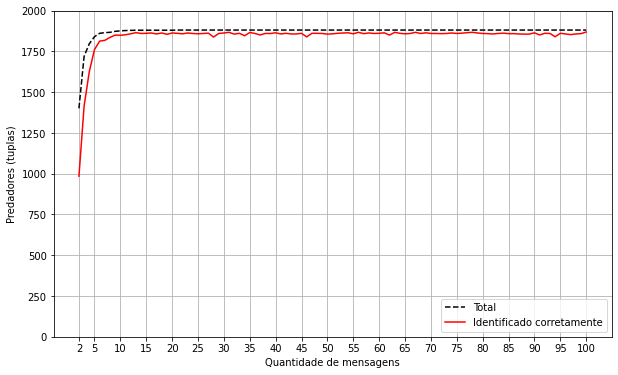

In [68]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators_tuples'], color='black', label='Total', linestyle='--')
# plt.plot(messages, metricsNN['identified_predators_tuples'], color='blue', label='Identificado', marker=marker, markerfacecolor='blue', markersize=markersize)
plt.plot(messages, metricsNN['correct_predators_tuples'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredatorsTuples)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores (tuplas)')
plt.grid(True)
plt.legend(loc='lower right')

**Predators**

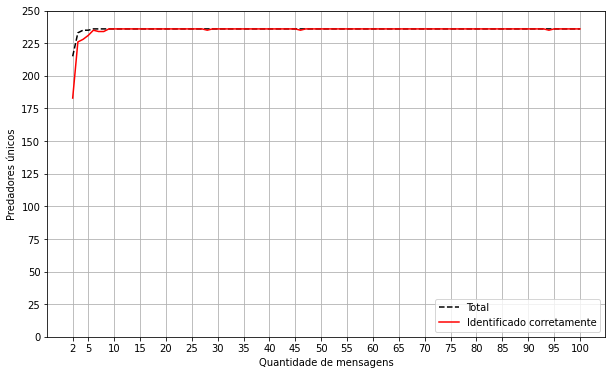

In [69]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['total_predators'], color='black', label='Total', linestyle='--')
plt.plot(messages, metricsNN['correct_predators'], color='red', label='Identificado corretamente', marker=marker, markerfacecolor='red', markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticksPredators)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Predadores únicos')
plt.grid(True)
plt.legend(loc='lower right')

**Accuracy**

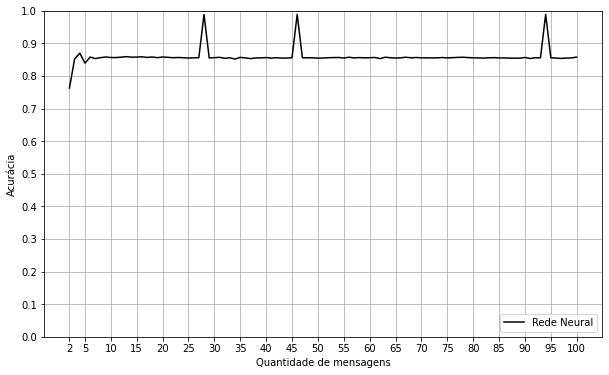

In [63]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['acc_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')

**Precision**

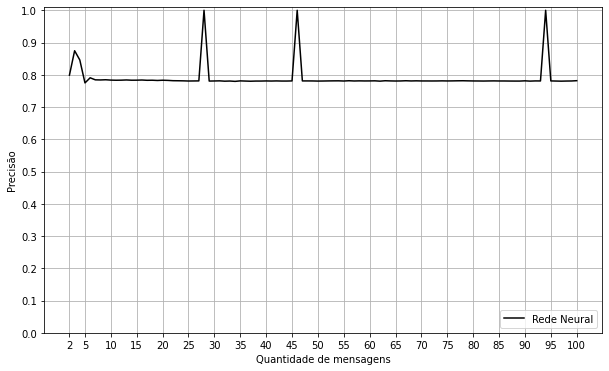

In [64]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['precision_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend(loc='lower right')

**Recall**

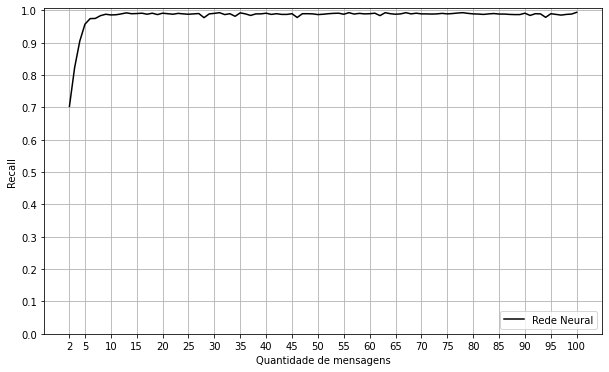

In [65]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['recall_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('Recall')
plt.grid(True)
plt.legend(loc='lower right')

**F1**

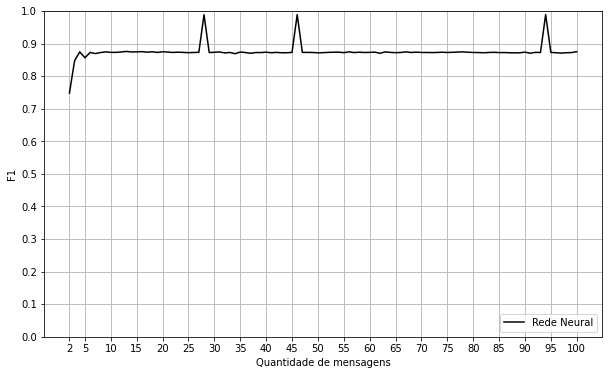

In [66]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f1_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F1')
plt.grid(True)
plt.legend(loc='lower right')

**F0.5**

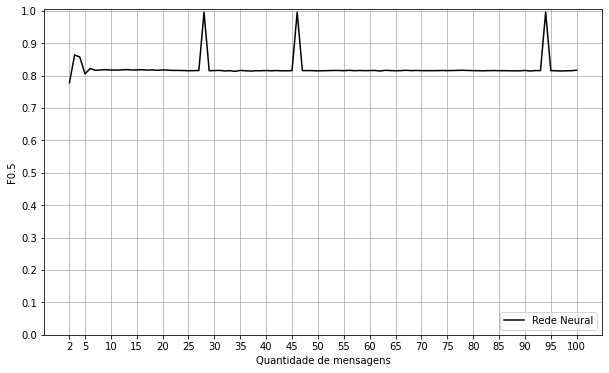

In [67]:
plt.figure(figsize=(10,6))
plt.plot(messages, metricsNN['f0_5_list'], color=colorNN, label=labelNN, marker=marker, markerfacecolor=colorNN, markersize=markersize)

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Quantidade de mensagens')
plt.ylabel('F0.5')
plt.grid(True)
plt.legend(loc='lower right')